In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import MaxNLocator
import scipy.integrate as integrate
import scipy.optimize as optimize
import scipy.misc as misc
import math
from numba import jit
from tqdm import tqdm
from matplotlib import animation
from IPython.display import HTML
from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Blocking method

Calculuate s. Choose simulationtime chopping at a simulationtimestep, when s plateaus

In [2]:
@jit
def S_calc(array, tau):
    
    std              = np.std(array)
    
    length           = len(array)
    N                = math.ceil(length/tau)
    
    array_chop       = np.array_split(array,N)
    
    array_chop_means = np.array(list(map(np.mean,array_chop)))
    
    std_chopped      = np.std(array_chop_means)
    
    result           = tau*std_chopped/std
    
    return result

In [3]:
def GET_TAU(array):
    
    step        = int(math.ceil(len(array)*0.0005))
    tau_range   = np.arange(1,int(len(array)*0.05+1), step)
    
    @jit
    def S_calc_func(tau):
        return S_calc(array, tau)
    
    s_array     = np.array(list(map(S_calc_func,tau_range)))
    
    s_array_par = s_array[:2]
    # total average
    avg_tot = np.mean(s_array_par)
    # partial average
    length  = len(s_array_par)
    avg_par = np.mean(s_array_par[int(length/2):])
    std     = np.std(s_array_par[int(length/2):])
    
    index = 2
    # check whether the partial average is inside the variance of total average
    while (avg_tot< avg_par-std or avg_tot> avg_par+std) and index<len(tau_range)-1:
        
        s           = s_array[index]
        index       = index+1
        s_array_par = s_array[:index]
        
        # total average
        avg_tot     = np.mean(s_array_par)
        # partial average
        length      = len(s_array_par)
        avg_par     = np.mean(s_array_par[int(length/2):])
        std         = np.std(s_array_par[int(length/2):])
    
    
    return tau_range[index], s_array

50

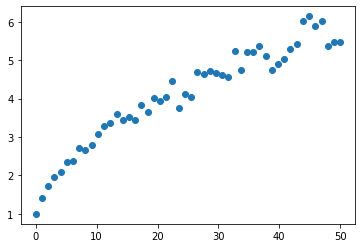

In [4]:
arrays = np.random.random(1000)
#print(array)
tau, s_array = GET_TAU(arrays)
time = np.linspace(0,len(s_array),len(s_array))
plt.scatter(time,s_array)
tau

# Initial conditions

Set a matrix of random spins (spin up: +1 or spin down: -1)\
**inital_int:**\
>matrix (L x L) with random spins

**initial_spin_up:**
>matrix (L x L) with 90% of spins up

**initial_spin_down:**
>matrix (L x L) with 90% of spins down

**timesteps:**
>time steps in which a random spin will be flipped

In [5]:
# Size of lattice
L = 40

# initial lattice
initial_int = np.random.randint(0,2,(L,L))
initial_int[initial_int==0]=-1

initial = np.random.random((L,L))

initial_spin_up = initial.copy()
initial_spin_up[initial<0.9]=1
initial_spin_up[initial>=0.9]=-1

initial_spin_down = initial.copy()
initial_spin_down[initial<0.9]=-1
initial_spin_down[initial>=0.9]= 1

# timesteps
timesteps = 100000

Calculate the energy at a given position in the matrix according to the Ising Model, from the nearest neightbour coupling. For the elements ont he borders of the matrix, use periodic boundary conditions.

In [6]:
@jit
def ENERGY(array, i_pos, j_pos):
    
    len_i, len_j = array.shape
    
    energy = 0
    spin_ij = array[i_pos,j_pos]
    
    energy += array[(i_pos+1)%len_i][j_pos]
    energy += array[(i_pos-1)%len_i][j_pos]
    energy += array[i_pos][(j_pos+1)%len_j]
    energy += array[i_pos][(j_pos-1)%len_j]
    
    #print(f'{array[(i_pos+1)%len_i][j_pos]},{array[(i_pos-1)%len_i][j_pos]},{array[i_pos][(j_pos+1)%len_j]},{array[i_pos][(j_pos-1)%len_j]}')
    energy = -energy *spin_ij
    return energy

Calculate the total energy in the array:

In [7]:
@jit
def TOTALENERGY(array):
    
    tot_energy = 0
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
            
            tot_energy += ENERGY(array,i,j)
    
    return tot_energy       

Test energy function:

In [8]:
%time print(f'Total energy: {TOTALENERGY(initial)}')

Total energy: -1601.3446131527528
CPU times: user 176 ms, sys: 773 µs, total: 177 ms
Wall time: 177 ms


# Metropolis algorithm

In [9]:
@jit
def METROPOLIS(initial_state,timesteps,Temperature):
    
    # Get shape of array
    len_i, len_j      = initial_state.shape
    
    lattice           = initial_state.copy()
    
    energy            = TOTALENERGY(initial_state)
    spin              = initial_state.sum()
    
    cumulative_energy = [energy]
    total_spin        = [spin]
    total_spin_squ    = [spin**2]
    
    for step in range(timesteps):
        
        # randomly select a position in the lattice
        i_pos, j_pos = (np.random.randint(0,len_i), np.random.randint(0,len_j))
        
        # Make new lattice with proposed spin flip
        lattice_new = lattice.copy()
        spin = lattice[i_pos][j_pos]
        lattice_new[i_pos][j_pos] = -1*spin
        #print(lattice)
        #print(f'new: {lattice_new[i_pos][j_pos]}, old: {lattice[i_pos][j_pos]}')
        
        # Calculate Energy difference between new and old lattice
        E_diff = ENERGY(lattice_new,i_pos, j_pos)-ENERGY(lattice,i_pos, j_pos)
        #print(f'new: {ENERGY(lattice_new,i_pos, j_pos)}, old: {ENERGY(lattice,i_pos, j_pos)}')
        
        # Check whether change will be accepted
        if E_diff <=0 or np.exp(-E_diff/Temperature)>np.random.random_sample():
            lattice = lattice_new.copy()
            # Change energy 
            energy += E_diff
        
        # Save energy
        cumulative_energy.append(energy)
        
        # Calculate total spin
        spin = lattice.sum()
        
        #print(f'i_pos: {i_pos}, j_pos: {j_pos}, E_diff: {E_diff} ,spin: {spin}')its 
        # Save spin 
        total_spin.append(spin)
        total_spin_squ.append(spin**2)
     
    return lattice, total_spin, total_spin_squ, cumulative_energy
    
    

# Test Metropolis Algorithm

In [10]:
state, spin, spin_squ, energy = METROPOLIS(initial_spin_up,timesteps,10)
state_T2, spin_T2, spin_squ_T2, energy_T2 = METROPOLIS(initial_spin_up,timesteps,2)
state_T3, spin_T3, spin_squ_T3, energy_T3 = METROPOLIS(initial_spin_up,timesteps,3)

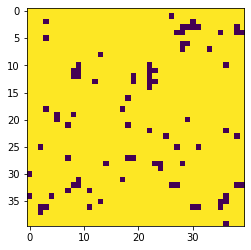

In [11]:
plt.imshow(state_T2)
plt.savefig('Pre_PhaseTransition_L40_T2.pdf', format='pdf')

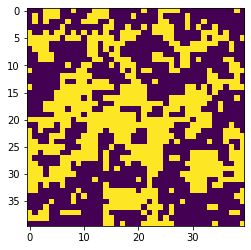

In [12]:
plt.imshow(state_T3)
plt.savefig('Post_PhaseTransition_L40_T3.pdf', format='pdf')

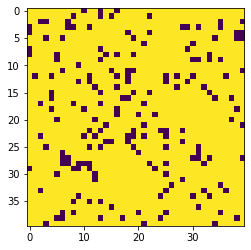

In [13]:
plt.imshow(initial_spin_up)


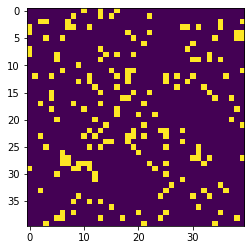

In [14]:
plt.imshow(initial_spin_down)

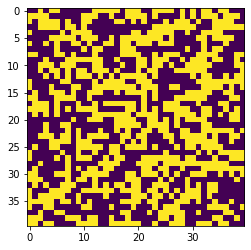

In [15]:
plt.imshow(state)

In [16]:
step_range = np.arange(0,timesteps+1)
print(f'steps: {len(step_range)}, energies: {len(energy_T2)}')

steps: 100001, energies: 100001


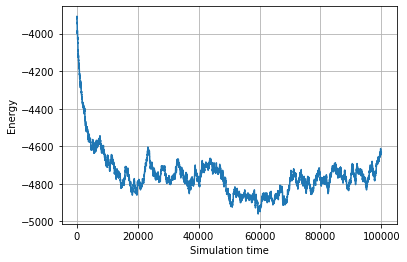

In [17]:
plt.plot(step_range,energy_T2)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Energy')
plt.savefig('Energy_over_time_L40_T2.pdf', format='pdf')

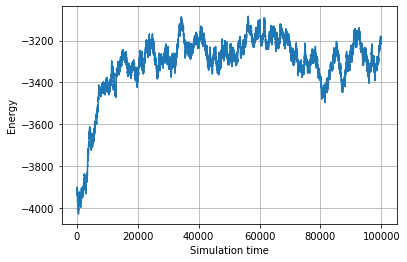

In [18]:
plt.plot(step_range,energy_T3)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Energy')
plt.savefig('Energy_over_time_L40_T3.pdf', format='pdf')

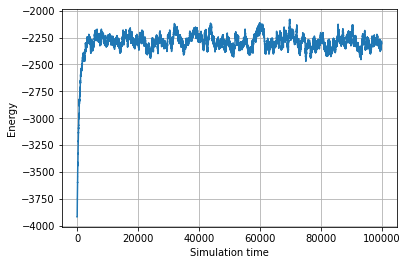

In [19]:
plt.plot(step_range,energy)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Energy')
plt.savefig('Energy_over_time_L40_T10.pdf', format='pdf')

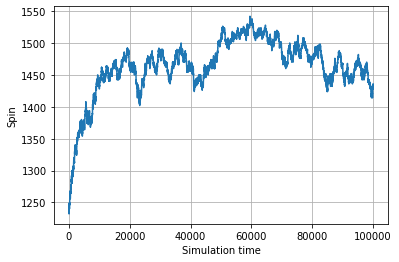

In [20]:
plt.plot(step_range,spin_T2)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Spin')
plt.savefig('Spin_over_time_L40_T2.pdf', format='pdf')

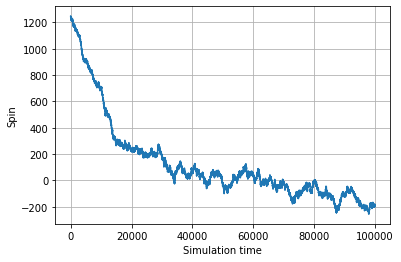

In [21]:
plt.plot(step_range,spin_T3)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Spin')
plt.savefig('Spin_over_time_L40_T3.pdf', format='pdf')

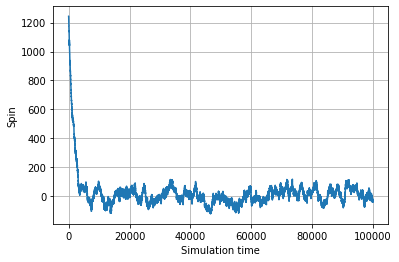

In [22]:
plt.plot(step_range,spin)
plt.grid()
plt.xlabel('Simulation time')
plt.ylabel('Spin')
plt.savefig('Spin_over_time_L40_T10.pdf', format='pdf')

# Magnetization

Calculate the Magnetization for different temperatures as a sum over the individual spins.

**Dependency between Magnetization and Temperature:**

Calculate:
>Magnetization over temperature\
>Susceptibility over temperature

In [23]:
@jit
def Get_Equilibrium(array):
    
    # Assumption: the last 15% of the simulation runs in equilibrium
    average = np.mean(array[int(len(array)*0.85):])
    
    if array[0]>average:
        index_list = np.argwhere(array<average)
        if len(index_list)>0:
            index=index_list[0][0]
        else:
            index=np.argwhere(array==np.amin(array))[0][0]
        
    else:
        index_list = np.argwhere(array>average)
        if len(index_list)>0:
            index=index_list[0][0]
        else:
            index=np.argwhere(array==np.amax(array))[0][0]                                    
        
    return index

In [24]:
@jit
def Blocking(array,cachesize):
    
    array_cached = np.array_split(array,cachesize)
    avg_array    = np.array(list(map(np.mean,array_cached)))
    
    avg_block    = np.mean(avg_array)
    std_block    = np.std(avg_array)
    
    return avg_block, std_block

In [25]:
def Magnetization_Temperature(Temprange,L,**kwargs):
    
    timesteps = kwargs.pop('timesteps', 120000)
    ensemble_n = kwargs.pop('ensemble_n', 3)
    
    magnetization      = []
    magnetization_err  = []
    susceptibility     = []
    susceptibility_err = []
    temperature        = []
    
    initial = np.random.random((L,L))

    initial_spin_up = initial.copy()
    initial_spin_up[initial<0.9]=1
    initial_spin_up[initial>=0.9]=-1
    
    for i in tqdm(range(len(Temprange))):
        
        T                     = Temprange[i]
        
        ensemble_spin         = []
        ensemble_spin_std     = []
        ensemble_spin_squ     = []
        ensemble_spin_std_squ = []
        
        
        for j in range(ensemble_n):
            
            state, spin, spin_squ, energy                      = METROPOLIS(initial_spin_up,timesteps,T)
            if j == 0:
                spin_lattice = state
            
            # Implement blocking method to find averages and variance
            # At which point is equilibrium achieved
            equilibrium_index                                  = Get_Equilibrium(spin)
            # Array of equilibrium spins
            equilibrium_spins                                  = spin[equilibrium_index:] 
            equilibrium_spins_squ                              = spin_squ[equilibrium_index:] 
            # Get size of caching of spin array for blocking method
            boxing, s_array                                    = GET_TAU(equilibrium_spins)
            
            avg_equilibrium_spin, std_equilibrium_spin         = Blocking(equilibrium_spins,boxing)
            avg_equilibrium_spin_squ, std_equilibrium_spin_squ = Blocking(equilibrium_spins_squ,boxing)
            
            #print(f'Temp: {T},equ index: {equilibrium_index}, boxing: {boxing}, avg+-std: {avg_equilibrium_spin}+-{std_equilibrium_spin}')
            
            ensemble_spin.append(avg_equilibrium_spin)
            ensemble_spin_std.append(std_equilibrium_spin)
            ensemble_spin_squ.append(avg_equilibrium_spin_squ)
            ensemble_spin_std_squ.append(std_equilibrium_spin_squ)

        
        avg_spin     = np.average(ensemble_spin)
        std_spin     = np.amax(ensemble_spin_std)
        
        avg_spin_squ = np.average(ensemble_spin_squ)
        std_spin_squ = np.amax(ensemble_spin_std_squ)
        
        
        magnetization.append(avg_spin)
        magnetization_err.append(std_spin)
        
        suscept      = L**2/T *(avg_spin_squ-avg_spin**2)
        suscept_err  = L**2/T *np.sqrt(std_spin_squ**2 + (2*avg_spin*std_spin)**2)
        
        susceptibility.append(suscept)
        susceptibility_err.append(suscept_err)
        
        temperature.append(T)
        
        np_m         = np.array(magnetization)
        np_m_err     = np.array(magnetization_err)
        np_s         = np.array(susceptibility)
        np_s_err     = np.array(susceptibility_err)
        
        
        
    return np.array([np_m,np_m_err]), np.array([np_s,np_s_err]), np.array(temperature), spin_lattice

In [26]:
Temprange = np.linspace(1,4,50)

%time magnetization_20, susceptibility_20, temperature_20, spin_lattice_20 = Magnetization_Temperature(Temprange,20)       

100%|█████████████████████████████████████████| 200/200 [21:01<00:00,  6.31s/it]

CPU times: user 20min 59s, sys: 1.95 s, total: 21min 1s
Wall time: 21min 1s


In [27]:
%time magnetization_40, susceptibility_40, temperature_40, spin_lattice_40 = Magnetization_Temperature(Temprange,40)

100%|█████████████████████████████████████████| 200/200 [17:59<00:00,  5.40s/it]

CPU times: user 17min 58s, sys: 1.52 s, total: 18min
Wall time: 17min 59s


In [28]:
%time magnetization_100, susceptibility_100, temperature_100, spin_lattice_100 = Magnetization_Temperature(Temprange,40)

100%|█████████████████████████████████████████| 200/200 [17:58<00:00,  5.39s/it]

CPU times: user 17min 57s, sys: 1.52 s, total: 17min 58s
Wall time: 17min 58s


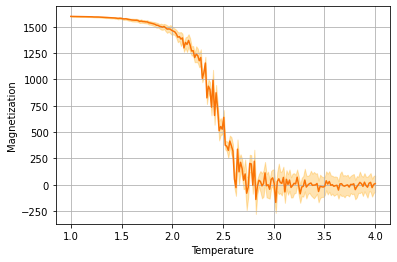

In [29]:
x   = temperature_100
y   = magnetization_100[0]
err = magnetization_100[1]

plt.plot(x, y, c = '#F97306')
plt.fill_between(x, y-err, y+err, alpha=0.3, color = '#FFA500')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.savefig('Spin_over_time_L100_T1-4.pdf', format='pdf')

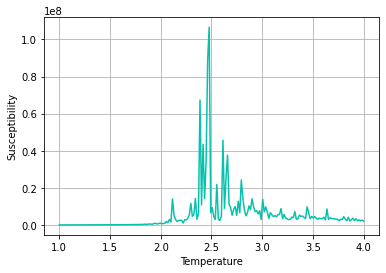

In [30]:
x   = temperature_100
y   = susceptibility_100[0]
err = susceptibility_100[1]

plt.plot(x, y, c='#06C2AC')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.savefig('Susceptibility_over_time_L100_T1-4.pdf', format='pdf')
#plt.fill_between(x, y-err, y+err, alpha=0.3, color='#40E0D0')

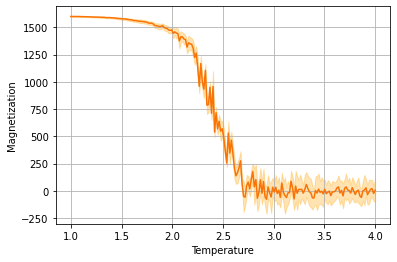

In [31]:
x   = temperature_40
y   = magnetization_40[0]
err = magnetization_40[1]

plt.plot(x, y, c = '#F97306')
plt.fill_between(x, y-err, y+err, alpha=0.3, color = '#FFA500')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.savefig('Spin_over_time_L40_T1-4.pdf', format='pdf')

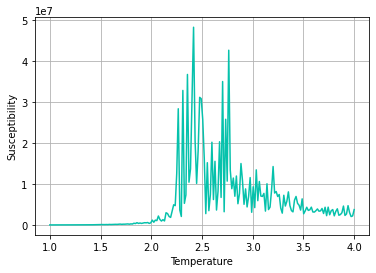

In [32]:
x   = temperature_40
y   = susceptibility_40[0]
err = susceptibility_40[1]

plt.plot(x, y, c='#06C2AC')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.savefig('Susceptibility_over_time_L40_T1-4.pdf', format='pdf')
#plt.fill_between(x, y-err, y+err, alpha=0.3, color='#40E0D0')

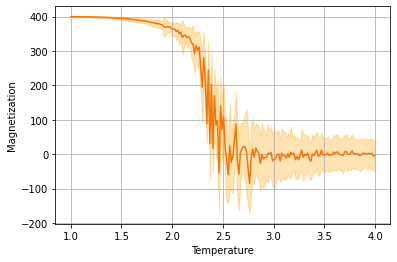

In [33]:
x   = temperature_20
y   = magnetization_20[0]
err = magnetization_20[1]

plt.plot(x, y, c = '#F97306')
plt.fill_between(x, y-err, y+err, alpha=0.3, color = '#FFA500')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Magnetization')
plt.savefig('Spin_over_time_L20_T1-4.pdf', format='pdf')

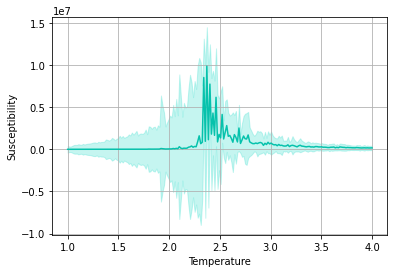

In [34]:
x   = temperature_20
y   = susceptibility_20[0]
err = susceptibility_20[1]

plt.plot(x, y, c='#06C2AC')
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Susceptibility')
plt.savefig('Susceptibility_over_time_L20_T1-4.pdf', format='pdf')
plt.fill_between(x, y-err, y+err, alpha=0.3, color='#40E0D0')
#plt.xlim([2.4,4])

**Autocorrelation of M(T):**

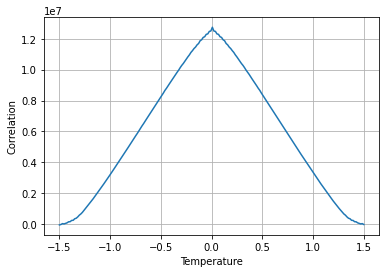

In [35]:
output_20 = np.correlate(magnetization_20[0],magnetization_20[0],mode='same')
lags_20   = temperature_20-1-(temperature_20[-1]-1)*0.5
plt.plot(lags_20,output_20)
#plt.xlim([0.55,2])
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Correlation')
plt.savefig('Autocorrelation_L20.pdf', format='pdf')

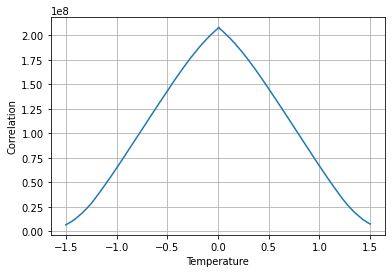

In [36]:
output_40 = np.correlate(magnetization_40[0],magnetization_40[0],mode='same')
lags_40   = temperature_20-temperature_40[-1]*0.5
plt.plot(lags_20,output_40)
#plt.xlim([0.55,2])
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Correlation')
plt.savefig('Autocorrelation_L40.pdf', format='pdf')

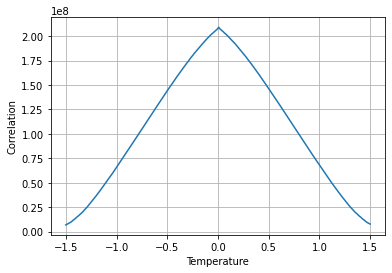

In [37]:
output_100 = np.correlate(magnetization_100[0],magnetization_100[0],mode='same')
lags_100   = temperature_100-temperature_100[-1]*0.5
plt.plot(lags_20,output_100)
#plt.xlim([0.55,2])
plt.grid()
plt.xlabel('Temperature')
plt.ylabel('Correlation')
plt.savefig('Autocorrelation_L100.pdf', format='pdf')

## Check finite scaling

In [ ]:
L_range            = np.linspace(20,110,5)
Temprange          = np.linspace(1,4,60)

magnetization_list = []
suscept_list       = []
spin_lattice_list  = []

for L in L_range:
    
    magnetization, susceptibility, temperature, spin_lattice = Magnetization_Temperature(Temprange,int(L))
    
    magnetization_list.append(magnetization)
    suscept_list.append(susceptibility)
    spin_lattice_list.append(spin_lattice)

 95%|████████████████████████████████████████▊  | 57/60 [05:03<00:16,  5.57s/it]

**Finite Scaling Analysis:**\
In this analysis the effects of the finite size of hte lattice onto the phasetransition are being investigated.

**Find susceptibility-maximum:**

In [ ]:
temp_max    = []
suscept_max = []

for suscept in suscept_list:
    
    maximum = np.amax(suscept[0])
    temp    = Temprange[suscept[0]==maximum][0]
    temp_max.append(temp)
    suscept_max.append(maximum)

In [ ]:
plt.scatter(L_range,temp_max)

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def bfunc(x, b_c, c, ba):
    return b_c-c*x**ba

In [ ]:
p0 = 2, 1, 1
popt, pcov = curve_fit(bfunc, L_range, temp_max, bounds = ([1,0,-10],[3,10,0]), maxfev = 10000)
popt

In [ ]:
y_data = bfunc(L_range,*popt)
plt.plot(L_range,y_data)
plt.scatter(L_range,temp_max)

**Plot:**

In [ ]:
def Finite_scaling(suscept_at_L, temperature, L_range, a, b, T_c):
    
    
    count = 0
    for i in range(len(L_range)):
        
        item = suscept_at_L[i]
        L    = L_range[i]
        
        
        suscept = item[0]
        
        count_1 = 0
        for index in range(len(temperature)):
            
            s = suscept[index]
            T = temperature[index]
            
            t = (T-T_c)/T_c
            x = L**(1/b)*t
            y = s*L**(-a/b)
            
            if count_1 == 0:
                
                x_arr   = np.array([x])
                y_arr   = np.array([y])
                count_1 = 1
                
            else:
    
                x_arr   = np.append(x_arr,[x],axis=0)
                y_arr   = np.append(y_arr,[y],axis=0)
            
        if count == 0:
                
            x_array     = np.array([x_arr])
            y_array     = np.array([y_arr])
            count       = 1
                
        else:
    
            x_array     = np.append(x_array,[x_arr],axis=0)
            y_array     = np.append(y_array,[y_arr],axis=0)
            
    
    return x_array, y_array

In [ ]:
T_c_sim, c_sim, b_sim = popt
print(popt)
parameter = -0.8

b   = -1/parameter
a   = 4
T_c = 2.45
print(f'a: {a}, b: {b}, T_c: {T_c}')

In [ ]:
print(Temprange)
print(L_range)

In [ ]:
point_size = 10

x_array, y_array = Finite_scaling(suscept_list, 
                                  Temprange, 
                                  L_range, 
                                  -1.7, # a
                                  -1, # b
                                  2.2) # T_c

plt.scatter(x_array[0],y_array[0],s=point_size)
plt.scatter(x_array[1],y_array[1],s=point_size)
plt.scatter(x_array[2],y_array[2],s=point_size)
plt.scatter(x_array[3],y_array[3],s=point_size)
plt.scatter(x_array[4],y_array[4],s=point_size)
plt.yscale("log")
plt.grid()
plt.xlabel(r'$L^{1/b}t$')
plt.ylabel(r'$x L^{-a/b}$')
plt.savefig('Finite_Scaling_a-1_7_b-1_2_2.pdf', format='pdf')

In [ ]:
point_size = 10

x_array, y_array = Finite_scaling(suscept_list, 
                                  Temprange, 
                                  L_range, 
                                  -1.7, # a
                                  -1, # b
                                  3) # T_c

plt.scatter(x_array[0],y_array[0],s=point_size)
plt.scatter(x_array[1],y_array[1],s=point_size)
plt.scatter(x_array[2],y_array[2],s=point_size)
plt.scatter(x_array[3],y_array[3],s=point_size)
plt.scatter(x_array[4],y_array[4],s=point_size)
plt.yscale("log")
plt.grid()
plt.xlabel(r'$L^{1/b}t$')
plt.ylabel(r'$x L^{-a/b}$')
plt.savefig('Finite_Scaling_Tc3.pdf', format='pdf')

In [ ]:
point_size = 10

x_array, y_array = Finite_scaling(suscept_list, 
                                  Temprange, 
                                  L_range, 
                                  -1.7, # a
                                  -1.9, # b
                                  1.6) # T_c

plt.scatter(x_array[0],y_array[0],s=point_size)
plt.scatter(x_array[1],y_array[1],s=point_size)
plt.scatter(x_array[2],y_array[2],s=point_size)
plt.scatter(x_array[3],y_array[3],s=point_size)
plt.scatter(x_array[4],y_array[4],s=point_size)
plt.yscale("log")
plt.grid()
plt.xlabel(r'$L^{1/b}t$')
plt.ylabel(r'$x L^{-a/b}$')
plt.savefig('Finite_Scaling_Tc1_6.pdf', format='pdf')

In [ ]:
len(np.multiply(x_array[0],y_array[0]/10))

In [ ]:
#a_range = np.linspace(-4,20,240)

a_range = [0,1,2,3,4]
a_values = np.zeros(len(a_range))
for j in range(len(a_range)):
    
    a = a_range[j]
    x_array, y_array = Finite_scaling(suscept_list,Temprange,L_range,a,-1,2.5)
    
    array = np.zeros(5)
    for i in [0,1,2,3,4]:
        
        x, y     = x_array[i], y_array[i]
        
        summe    = np.sum(y)
        
        weighted = np.multiply(x,y/summe)
        
        array[i] = np.sum(weighted)
        
    mittel   = np.mean(array)
    #print(mittel)
    dist        = np.sum(np.absolute(array-mittel))
    a_values[j] = dist
    print()
    
plt.plot(a_range,a_values)
print(a_values)

In [ ]:
x_array, y_array = Finite_scaling(suscept_list, 
                                  Temprange, 
                                  L_range, 
                                  a, # a
                                  b, # b
                                  T_c) # T_c

plt.scatter(x_array[0],y_array[0])
plt.scatter(x_array[1],y_array[1])
plt.scatter(x_array[2],y_array[2])
plt.scatter(x_array[3],y_array[3])
plt.scatter(x_array[4],y_array[4])

In [ ]:
plt.scatter(x_array[0],y_array[0])

In [ ]:
plt.scatter(x_array[1],y_array[1])

In [ ]:
plt.scatter(x_array[2],y_array[2])

In [ ]:
plt.scatter(x_array[3],y_array[3])

In [ ]:
plt.scatter(x_array[4],y_array[4])